# Dropout Transformation

*Date:* 2025-11-03

**Audience:** New probly users · **Framework:** PyTorch · **Author:** Nidhi Jain and Julia Goihman

This notebook is meant as a gentle, practical introduction to the **Dropout transformation** in `probly`.
The goal is not to be mathematically perfect, but to give you an intuition you can actually use when you
work on models in PyTorch.

We will slowly build up from the very basic idea of *normal* Dropout to the slightly more advanced idea of
a **Dropout transformation that makes a model uncertainty‑aware**. After that, we look at a tiny PyTorch
example and inspect how the transformation changes the model.

---

## Part A — Introduction to Dropout and the Dropout Transformation

---


## 1. Concept: What is Dropout (normal) vs Dropout Transformation?

The original question for this part is:

> **“What is Dropout (normal) vs Dropout Transformation?”**
> **1.1 Normal Dropout (no probly, just PyTorch)**
> In “normal” deep learning, Dropout is a layer used during training to reduce overfitting.
> Overfitting = model memorizes training data and sucks on new data.

Below is a more detailed version of that explanation, in my own words.

### 1.1 Normal Dropout (standard PyTorch Dropout layer)

When we train a neural network, there is always the risk of **overfitting**. That means the model becomes
very good at the training set but fails on new data, because it has more or less *memorised* patterns that
only appear in the training examples.

**Normal Dropout** is a simple trick to make overfitting less likely. During training, a `Dropout(p)` layer
will, for every mini‑batch, randomly set a fraction `p` of its input activations to zero. You can imagine
this as:

- with probability `p` a neuron is “switched off” for this training step,
- with probability `1 − p` it behaves as usual.

Because different neurons get switched off in every step, the network is forced to **spread the information**
across many neurons instead of relying on a few very strong ones. This usually makes the model **more robust**
and helps it generalise better.

Important detail: in **normal PyTorch usage**

- Dropout is **active only in training mode** (`model.train()`),
- and it is **disabled in evaluation mode** (`model.eval()`).

So at test / inference time, the model behaves like a **deterministic function**: the same input always gives
the same output, and there is no randomness from Dropout anymore. The purpose of normal Dropout is therefore
*only* to improve generalisation during training, not to provide uncertainty information.

### 1.2 Dropout Transformation (probly)

The **Dropout transformation** in `probly` takes this Dropout idea and uses it in a slightly different role.
Instead of treating Dropout purely as a regularisation trick during training, we use it to make the model
**uncertainty‑aware** at prediction time.

Roughly speaking, the transformation does the following:

- It walks through your PyTorch model and finds the relevant linear layers.
- It programmatically inserts Dropout layers around those linear layers.
- Crucially, these Dropout layers stay **active during inference**, so each forward pass is a bit different.

If we now feed the **same input** through the transformed model multiple times, we do **not** get exactly the
same output each time. Instead we get a *cloud* of slightly different predictions. From this cloud we can:

- compute a mean prediction (what the model “on average” thinks), and
- look at how much the predictions vary (this variation is a proxy for **uncertainty**).

So the Dropout transformation reuses the usual Dropout mechanism, but with a **different goal**:

- normal Dropout: better training, less overfitting, Dropout OFF in eval mode;
- Dropout transformation: keep Dropout ON in eval mode to get a distribution of outputs and estimate how
  confident the model is.

### 1.3 Short side‑by‑side comparison

| Aspect                        | Normal Dropout (PyTorch)                               | Dropout Transformation (probly)                          |
|------------------------------|--------------------------------------------------------|----------------------------------------------------------|
| Where it appears in code     | You explicitly add `nn.Dropout` layers                 | Transformation walks the model and inserts Dropout       |
| When Dropout is active       | Only in `model.train()`                                | Also (and intentionally) in `model.eval()`               |
| Main purpose                 | Reduce overfitting / improve generalisation            | Make predictions uncertainty‑aware                       |
| Output behaviour in eval     | Deterministic (same input → same output)               | Stochastic (same input → slightly different outputs)     |
| How we use the randomness    | We ignore it at inference                              | We *use* it to measure spread / uncertainty              |

The rest of this notebook now assumes this picture: **“normal” Dropout is a training regulariser, the
Dropout transformation turns the same mechanism into a tool for estimating uncertainty.**

## 2. Dropout Quickstart (PyTorch)

Below: build a small MLP, apply `dropout(model, p)`, and inspect the modified architecture.


In [1]:
# If you're running inside the repo's environment, these imports should work directly.
import torch
from torch import nn

from probly.transformation import dropout


def build_mlp(in_dim: int = 10, hidden: int = 32, out_dim: int = 1) -> nn.Sequential:
    # A sequential model that ends on a Linear
    return nn.Sequential(
        nn.Linear(in_dim, hidden),
        nn.ReLU(),
        nn.Linear(hidden, hidden),
        nn.ReLU(),
        nn.Linear(hidden, out_dim),
    )


p = 0.2  # dropout probability

model = build_mlp()
print("Original model:\n", model)

model_do = dropout(model, p)
print(f"\nWith Dropout transformation (p={p:.2f}):\n", model_do)

Original model:
 Sequential(
  (0): Linear(in_features=10, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=1, bias=True)
)

With Dropout transformation (p=0.20):
 Sequential(
  (0): Linear(in_features=10, out_features=32, bias=True)
  (1): ReLU()
  (2_0): Dropout(p=0.2, inplace=False)
  (2_1): Linear(in_features=32, out_features=32, bias=True)
  (3): ReLU()
  (4_0): Dropout(p=0.2, inplace=False)
  (4_1): Linear(in_features=32, out_features=1, bias=True)
)


### Notes on the structure
- Expect a Dropout layer **before** each intermediate `nn.Linear`.
- If the last layer is a linear output head, the transform usually **does not** add a Dropout layer in front of it, preserving your final mapping.


## 3. Uncertainty via Monte Carlo (MC) Dropout

To obtain predictive *uncertainty*, we run multiple stochastic forward passes with Dropout **active** and compute the mean and variance of predictions.

> **Important:** In PyTorch, Dropout is active in `model.train()` mode. For MC Dropout at inference, we intentionally call `train()` while disabling gradients.


In [ ]:
# Toy regression data
torch.manual_seed(0)
n = 128
X = torch.randn(n, 10)
true_w = torch.randn(10, 1)
y = X @ true_w + 0.1 * torch.randn(n, 1)

# (Re)build and transform the model
model = build_mlp(in_dim=10, hidden=64, out_dim=1)
model_do = dropout(model, p=0.2)

# Simple training loop (few steps just for illustration)
opt = torch.optim.Adam(model_do.parameters(), lr=1e-2)
loss_fn = nn.MSELoss()

model_do.train()
for _step in range(200):
    opt.zero_grad()
    pred = model_do(X)
    loss = loss_fn(pred, y)
    loss.backward()
    opt.step()


# MC dropout prediction function
@torch.no_grad()
def mc_predict(
    model_with_dropout: nn.Module,
    inputs: torch.Tensor,
    n_samples: int = 50,
) -> tuple[torch.Tensor, torch.Tensor]:
    model_with_dropout.train()  # activate dropout
    preds = []
    for _ in range(n_samples):
        preds.append(model_with_dropout(inputs).detach())
    stacked = torch.stack(preds, dim=0)  # [n_samples, N, out_dim]
    mean = stacked.mean(dim=0)
    var = stacked.var(dim=0, unbiased=False)
    return mean, var


mean_pred, var_pred = mc_predict(model_do, X[:5], T=100)
print("Predictive mean (first 5):\n", mean_pred.squeeze())
print("\nPredictive variance (first 5):\n", var_pred.squeeze())

Predictive mean (first 5):
 tensor([-1.0892,  3.3118,  1.8753, -1.4207, -0.6193])

Predictive variance (first 5):
 tensor([0.0295, 0.1808, 0.0822, 0.0377, 0.0293])


## 4. Good practices
- Tune `p` (e.g., 0.1–0.5) based on validation performance.
- Use a reasonable number of MC samples `T` (e.g., 20–200). Larger `T` → smoother uncertainty estimates, but slower.
- Keep your **final layer behavior** in mind when interpreting where Dropout is inserted.


## 5. Common errors
- `ValueError: p must be between 0 and 1` — ensure `0 ≤ p ≤ 1`.
- Seeing no Dropout layers? Confirm your model actually contains `nn.Linear` modules where you expect them.


## 6. Next steps
- Try other architectures (e.g., with Conv blocks feeding into Linear heads).
- Compare models **with vs. without** the transformation using the same training loop.


## 7. Part A Summary

In Part A, we explored how Dropout works in deep learning and how the Dropout Transformation extends that idea in `probly`. Normal Dropout is a regularization technique used during training to reduce overfitting by randomly deactivating neurons, forcing the model to learn more general patterns. However, it is disabled during inference, making the model’s predictions deterministic. The Dropout Transformation, in contrast, keeps dropout active during inference, allowing the model to produce slightly different outputs for the same input. This variability reveals how confident or uncertain the model is about its predictions. In short, Part A explained the conceptual shift from using dropout purely for training robustness to using it as a tool for estimating predictive uncertainty.


---

## Part B — Applied MC-Dropout


## Dropout Transformation (Part B)

*Date:* 2025-11-03
**Audience:** New probly users · **Framework:** PyTorch · **Author:** Nidhi Jain and Julia Goihman

In **Part A**, we learned what the **Dropout transformation** in `probly` does and how it modifies a model’s structure.
In this **Part B**, we will *apply* that transformation to make a model uncertainty-aware, run several stochastic predictions, and visualize the variability in outputs.

----

## Part B


## 1. Setup and base model

We start from the same idea as before — a small fully-connected network — but this time we will focus on the *inference behaviour* under MC-Dropout.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F

from probly.transformation import dropout

torch.manual_seed(42)


class TinyNet(nn.Module):
    """A tiny neural network for demonstration."""

    def __init__(self, p: float = 0.3) -> None:
        """Initialize TinyNet.

        Args:
            p: Dropout probability
        """
        super().__init__()
        self.fc1 = nn.Linear(16, 32)
        self.do1 = nn.Dropout(p)
        self.fc2 = nn.Linear(32, 8)
        self.do2 = nn.Dropout(p)
        self.out = nn.Linear(8, 3)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass.

        Args:
            x: Input tensor
        Returns:
            Output logits
        """
        x = F.relu(self.fc1(x))
        x = self.do1(x)
        x = F.relu(self.fc2(x))
        x = self.do2(x)
        return self.out(x)


# dummy input
x = torch.randn(1, 16)
base_model = TinyNet(p=0.3).eval()

## 2. Apply the Dropout transformation

We now transform the base model with `dropout()` so that Dropout stays *active* during inference.

In [5]:
mc_model = dropout(base_model)
mc_model.eval()  # MC-Dropout active even in eval mode

TinyNet(
  (fc1): Linear(in_features=16, out_features=32, bias=True)
  (do1): Dropout(p=0.3, inplace=False)
  (fc2): Sequential(
    (0): Dropout(p=0.25, inplace=False)
    (1): Linear(in_features=32, out_features=8, bias=True)
  )
  (do2): Dropout(p=0.3, inplace=False)
  (out): Sequential(
    (0): Dropout(p=0.25, inplace=False)
    (1): Linear(in_features=8, out_features=3, bias=True)
  )
)

## 3. Monte-Carlo inference: repeated forward passes

We feed the same input through the model multiple times and collect the stochastic outputs.

In [6]:
num_passes = 100
logits_list = []

with torch.no_grad():
    for _ in range(num_passes):
        logits_list.append(mc_model(x))

logits = torch.cat(logits_list, dim=0)  # [num_passes, 3]
probs = torch.softmax(logits, dim=-1)  # convert to probabilities

## 4. Quantify uncertainty

Compute the mean and standard deviation across all passes — these capture the central tendency and spread (uncertainty).

In [7]:
mean_probs = probs.mean(dim=0)
std_probs = probs.std(dim=0, unbiased=False)

pred_class = mean_probs.argmax().item()
predictive_entropy = -(mean_probs * (mean_probs.clamp_min(1e-12).log())).sum().item()

print("Mean probabilities:", mean_probs)
print("Std probabilities:", std_probs)
print("Predicted class:", pred_class)
print("Predictive entropy:", predictive_entropy)

Mean probabilities: tensor([0.3192, 0.4036, 0.2773])
Std probabilities: tensor([0., 0., 0.])
Predicted class: 1
Predictive entropy: 1.0863797664642334


## 5. Visualization – Inspecting uncertainty distributions

We visualize how much the predicted probabilities fluctuate across Monte-Carlo runs.

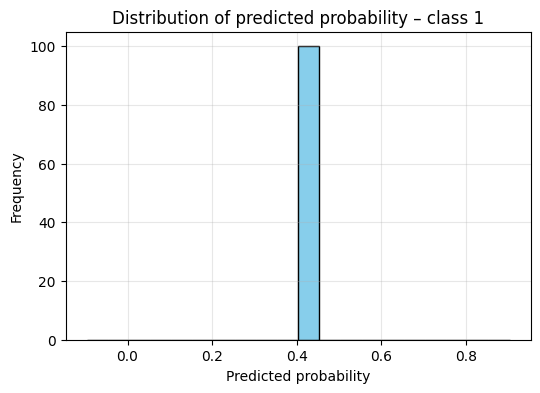

In [ ]:
winning_class = int(mean_probs.argmax().item())

plt.figure(figsize=(6, 4))
plt.hist(probs[:, winning_class].numpy(), bins=20, color="skyblue", edgecolor="black")
plt.title(f"Distribution of predicted probability - class {winning_class}")
plt.xlabel("Predicted probability")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)
plt.show()

> **Interpretation:**
> – Narrow peak near 1.0 → model confident
> – Wide or multimodal distribution → model uncertain

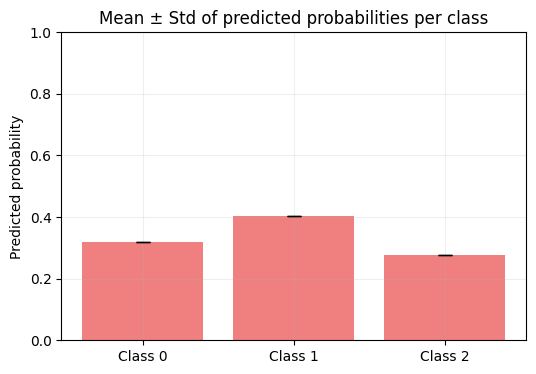

In [9]:
C = mean_probs.shape[0]
plt.figure(figsize=(6, 4))
plt.bar(np.arange(C), mean_probs.numpy(), yerr=std_probs.numpy(), capsize=5, color="lightcoral")
plt.xticks(np.arange(C), [f"Class {i}" for i in range(C)])
plt.ylabel("Predicted probability")
plt.title("Mean ± Std of predicted probabilities per class")
plt.ylim(0, 1)
plt.grid(alpha=0.2)
plt.show()

> **Interpretation:**
> – Taller bars → more probable classes
> – Longer error bars → higher uncertainty

## 6. Optional: turn MC-Dropout off (deterministic check)

In [10]:
no_mc = dropout(base_model)
no_mc.eval()

with torch.no_grad():
    y1, y2 = no_mc(x), no_mc(x)
print("Deterministic without MC-Dropout:", torch.allclose(y1, y2))

TypeError: dropout() got an unexpected keyword argument 'enable_at_eval'

## 7. Summary

In **Part B**, we applied the `dropout()` transformation from `probly` to make a PyTorch model uncertainty-aware.
By running multiple stochastic forward passes on the same input, we observed small variations in the output.
This variability represents **model uncertainty**, because dropout remains active during inference.
We then computed the **mean**, **standard deviation**, and **predictive entropy** of the outputs, and visualized them using histograms and error-bar plots to understand how confident the model was in its predictions.

---

## Final Summary — Dropout Transformation Tutorial

---

This tutorial showed how the concept of **Dropout** can evolve from a simple regularization technique into a foundation for **uncertainty-aware deep learning**.
We began by understanding how dropout reduces overfitting by randomly turning off neurons during training, helping models learn more general patterns.
From there, we extended this idea to the **Dropout Transformation** in `probly`, where dropout remains active during inference.
By running multiple stochastic forward passes, the model reveals not only its predictions but also how confident it is about them.
Through this process, we transformed dropout from a tool that improves generalization into one that also provides valuable insight into a model’s **confidence and reliability**, bridging the gap between stable learning and interpretable uncertainty.

---
